In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder 
from lr.stats.h_testing import get_paired_t_statistic

from glob import glob

# P-value cloud

In [2]:
folder = "snli"

all_paired_t_p_values_snli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
    
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_snli.append(paired_t_p_value)
    
all_paired_t_p_values_snli = pd.concat(all_paired_t_p_values_snli, 1)
all_paired_t_p_values_snli.columns = batchs

folder = "mnli"

all_paired_t_p_values_mnli = []

test_repetitions = 5
batchs = range(1, test_repetitions + 1)

for i in tqdm(batchs):
        
    paired_t_p_value  = get_ts_from_results_folder(path="results/{}/xgb/syn_p_h/batch{}/".format(folder, i),
                                                    stat="paired_t_p_value")
    
    all_paired_t_p_values_mnli.append(paired_t_p_value)
    
all_paired_t_p_values_mnli = pd.concat(all_paired_t_p_values_mnli, 1)
all_paired_t_p_values_mnli.columns = batchs

100%|██████████| 5/5 [00:01<00:00,  3.99it/s]


In [3]:
def get_cloud_p_values(p_values_df, alpha=0.05, test_repetitions=5):    
    rhos = p_values_df.index
    mean_p_values = p_values_df.mean(1).values
    error_p_values = p_values_df.std(1).values
    min_p_values  = p_values_df.min(1).values


    alpha_adj = alpha / test_repetitions

    rejected_ids = []
    remain_ids = []

    for i,p in enumerate(min_p_values):
        if p < alpha_adj:
            rejected_ids.append(i)
        else:
            remain_ids.append(i)

    rhos_rejected = rhos[rejected_ids]
    rhos_remain = rhos[remain_ids]
    y_rejected = mean_p_values[rejected_ids]
    y_remain = mean_p_values[remain_ids]
    error_rejected = error_p_values[rejected_ids]
    error_remain = error_p_values[remain_ids]
    return rhos_rejected, rhos_remain, y_rejected, y_remain, error_rejected, error_remain

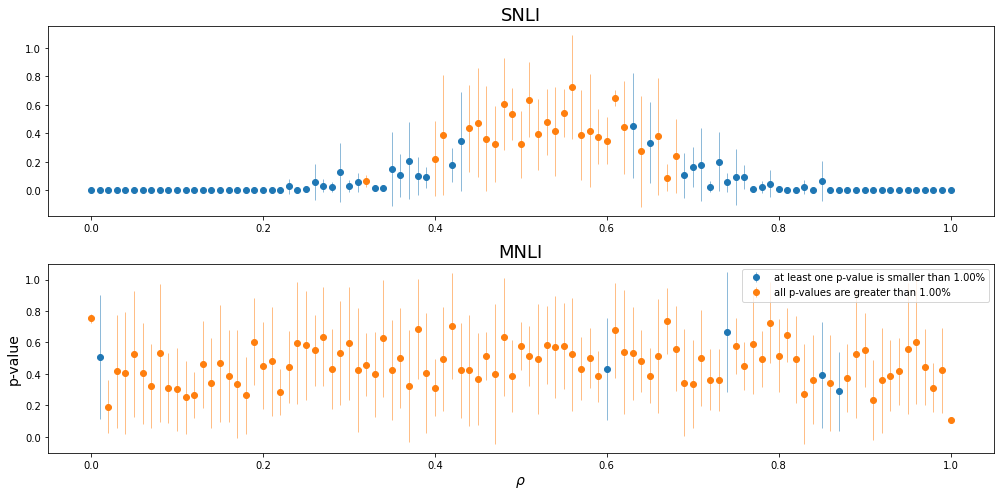

In [4]:
rhos_rejected_snli, rhos_remain_snli, y_rejected_snli, y_remain_snli, error_rejected_snli, error_remain_snli = get_cloud_p_values(all_paired_t_p_values_snli)
rhos_rejected_mnli, rhos_remain_mnli, y_rejected_mnli, y_remain_mnli, error_rejected_mnli, error_remain_mnli = get_cloud_p_values(all_paired_t_p_values_mnli)

alpha = 0.05
alpha_adj = alpha / test_repetitions



fig, ax = plt.subplots(2,figsize=(14,7))
ax[0].errorbar(rhos_rejected_snli, y_rejected_snli, yerr=error_rejected_snli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[0].errorbar(rhos_remain_snli, y_remain_snli, yerr=error_remain_snli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_rejected_mnli, y_rejected_mnli, yerr=error_rejected_mnli, fmt='o', linewidth=0.50, label="at least one p-value is smaller than {:.2%}".format(alpha_adj));
ax[1].errorbar(rhos_remain_mnli, y_remain_mnli, yerr=error_remain_mnli, fmt='o', linewidth=0.50, label="all p-values are greater than {:.2%}".format(alpha_adj));
ax[1].legend(loc="best");
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("p-value", fontsize=14);
ax[1].set_title("MNLI", fontsize=18);
ax[0].set_title("SNLI", fontsize=18);
fig.tight_layout()
fig.tight_layout()
fig.savefig('figs/paper/baseline_p_values_cloud.png', bbox_inches=None, pad_inches=0.5)

# t-stat for each category

In [5]:
def get_ts_from_path(base_path, nli_map):
    rhos = []
    neutral_t = []
    contradiction_t = []
    entailment_t = []
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_n = df.query("label=='neutral'")
        df_c = df.query("label=='contradiction'")
        df_e = df.query("label=='entailment'")
        t_n, _,_,_ = get_paired_t_statistic(df_n)
        t_c, _,_,_ = get_paired_t_statistic(df_c)
        t_e, _,_,_ = get_paired_t_statistic(df_e)
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)
        neutral_t.append(t_n)
        contradiction_t.append(t_c)
        entailment_t.append(t_e)
        rhos.append(rho)

    neutral_t = pd.Series(neutral_t,index=rhos).sort_index()
    contradiction_t = pd.Series(contradiction_t,index=rhos).sort_index()
    entailment_t = pd.Series(entailment_t,index=rhos).sort_index()
    neutral_t.name = "neutral"
    contradiction_t.name = "contradiction"
    entailment_t.name = "entailment"
    return neutral_t, contradiction_t, entailment_t

In [6]:
nli2ternary = {1: "entailment",
               -1: "contradiction",
               0: "neutral"}

folder = "snli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_n_snli = []
all_c_snli = []
all_e_snli = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_snli.append(neutral_t)
    all_c_snli.append(contradiction_t)
    all_e_snli.append(entailment_t)
    
all_n_snli = pd.concat(all_n_snli, 1)
all_c_snli = pd.concat(all_c_snli, 1)
all_e_snli = pd.concat(all_e_snli, 1)

folder = "mnli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_n_mnli = []
all_c_mnli = []
all_e_mnli = []

for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    neutral_t, contradiction_t, entailment_t = get_ts_from_path(base_path=base_path, nli_map=nli2ternary)
    all_n_mnli.append(neutral_t)
    all_c_mnli.append(contradiction_t)
    all_e_mnli.append(entailment_t)
    
all_n_mnli = pd.concat(all_n_mnli, 1)
all_c_mnli = pd.concat(all_c_mnli, 1)
all_e_mnli = pd.concat(all_e_mnli, 1)

df_snli = pd.concat([all_n_snli.mean(1), all_c_snli.mean(1), all_e_snli.mean(1)], 1)
df_mnli = pd.concat([all_n_mnli.mean(1), all_c_mnli.mean(1), all_e_mnli.mean(1)], 1)
df_snli.columns = ["neutral", "contradiction", "entailment"]
df_mnli.columns = ["neutral", "contradiction", "entailment"]
corr_snli = df_snli.corr()
mask_snli = np.triu(np.ones_like(corr_snli, dtype=bool))
corr_mnli = df_mnli.corr()
mask_mnli = np.triu(np.ones_like(corr_mnli, dtype=bool))

100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


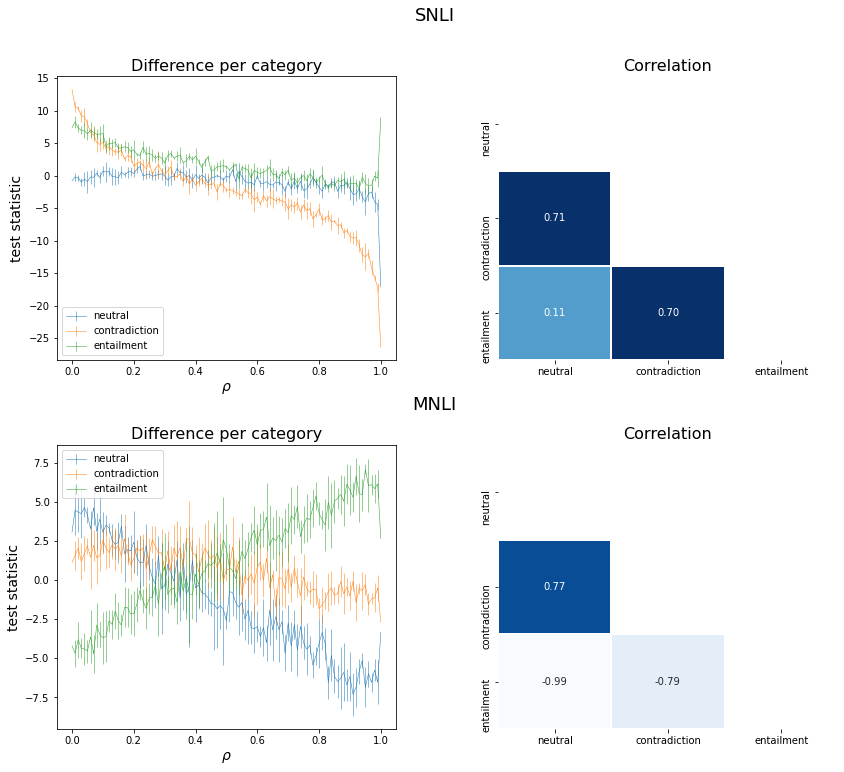

In [7]:
fig, ax = plt.subplots(2,2, figsize=(14,12))
ax[0,0].errorbar(all_n_snli.index, all_n_snli.mean(1), yerr=all_n_snli.std(1), fmt='-', linewidth=0.50, label="neutral");
ax[0,0].errorbar(all_c_snli.index, all_c_snli.mean(1), yerr=all_c_snli.std(1), fmt='-', linewidth=0.50, label="contradiction");
ax[0,0].errorbar(all_e_snli.index, all_e_snli.mean(1), yerr=all_e_snli.std(1), fmt='-', linewidth=0.50, label="entailment");
ax[0,0].set_xlabel(r"$\rho$", fontsize=14);
ax[0,0].set_ylabel("test statistic", fontsize=14);
ax[0,0].legend(loc="best");
# ax[0,0].hlines(0, 0, 1, colors='k',linestyles="--") 

sns.heatmap(corr_snli, mask=mask_snli, cmap="Blues", center=0, linewidths=1, annot=True, fmt=".2f",cbar=False, ax=ax[0,1]);

ax[1,0].errorbar(all_n_mnli.index, all_n_mnli.mean(1), yerr=all_n_mnli.std(1), fmt='-', linewidth=0.50, label="neutral");
ax[1,0].errorbar(all_c_mnli.index, all_c_mnli.mean(1), yerr=all_c_mnli.std(1), fmt='-', linewidth=0.50, label="contradiction");
ax[1,0].errorbar(all_e_mnli.index, all_e_mnli.mean(1), yerr=all_e_mnli.std(1), fmt='-', linewidth=0.50, label="entailment");
sns.heatmap(corr_mnli, mask=mask_mnli, cmap="Blues", center=0, linewidths=1, annot=True, fmt=".2f",cbar=False, ax=ax[1,1]);
ax[1,0].set_xlabel(r"$\rho$", fontsize=14);
ax[1,0].set_ylabel("test statistic", fontsize=14);
ax[1,0].legend(loc="best");
# ax[1,0].hlines(0, 0, 1, colors='k',linestyles="--")

# Adjust vertical_spacing = 0.5 * axes_height
plt.subplots_adjust(hspace=0.3, wspace=0.3)


# Add text in figure coordinates
plt.figtext(0.5, 0.5, 'MNLI', ha='center', va='center',fontsize=18);
plt.figtext(0.5, 0.95, 'SNLI', ha='center', va='center',fontsize=18);


ax[0,0].set_title("Difference per category", fontsize=16);
ax[0,1].set_title("Correlation", fontsize=16);
ax[1,0].set_title("Difference per category", fontsize=16);
ax[1,1].set_title("Correlation", fontsize=16);

fig.savefig('figs/paper/baseline_t_stas_cat.png', bbox_inches=None, pad_inches=0.5)

# Entailment accuracy

In [8]:
def get_acc_from_ent(base_path, nli_map):
    rhos = []
    entailment_acc = []
    entailment_acc_t = []
    
    paths =  glob(base_path)

    for path in paths:
        df = pd.read_csv(path)
        df.label = df.label.map(lambda x: nli_map[x])
        df_e = df.query("label=='entailment'")
        rho = path.split("/")[-1].split("_")[1].replace("p",".")
        rho = float(rho)

        entailment_acc.append(df_e.A.mean())
        entailment_acc_t.append(df_e.B.mean())        
        rhos.append(rho)

    entailment_acc = pd.Series(entailment_acc,index=rhos).sort_index()
    entailment_acc_t = pd.Series(entailment_acc_t,index=rhos).sort_index()
    entailment_acc.name = "original accuracy"
    entailment_acc_t.name = "transformed accuracy"
    return entailment_acc, entailment_acc_t

In [9]:
folder = "snli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_e_snli_acc = []
all_e_snli_acc_t = []


for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    entailment_acc, entailment_acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    all_e_snli_acc.append(entailment_acc)
    all_e_snli_acc_t.append(entailment_acc_t)
    
all_e_snli_acc = pd.concat(all_e_snli_acc, 1)
all_e_snli_acc_t = pd.concat(all_e_snli_acc_t, 1)


folder = "mnli"
test_repetitions = 5
batchs = range(1, test_repetitions + 1)
all_e_mnli_acc = []
all_e_mnli_acc_t = []


for i in tqdm(batchs):
    base_path = "raw_results/{}/xgb/syn_p_h/batch{}/*.csv".format(folder, i)
    entailment_acc, entailment_acc_t = get_acc_from_ent(base_path=base_path, nli_map=nli2ternary)
    all_e_mnli_acc.append(entailment_acc)
    all_e_mnli_acc_t.append(entailment_acc_t)
    
all_e_mnli_acc = pd.concat(all_e_mnli_acc, 1)
all_e_mnli_acc_t = pd.concat(all_e_mnli_acc_t, 1)



100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


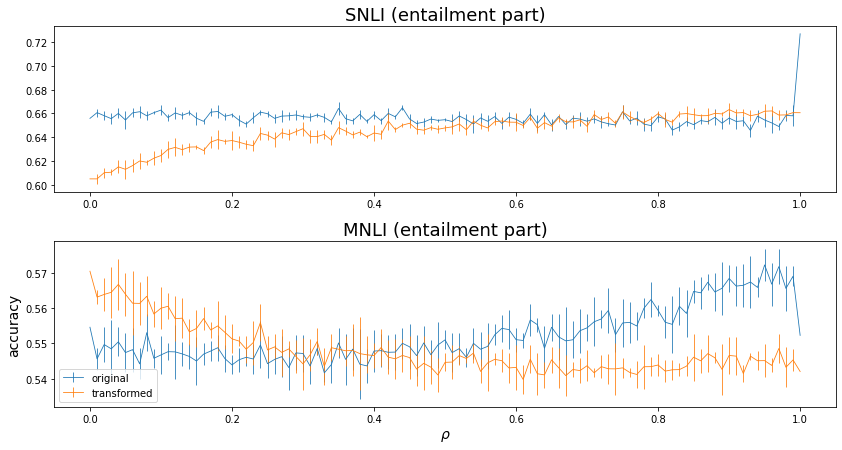

In [10]:
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0].errorbar(all_e_snli_acc.index, all_e_snli_acc.mean(1), yerr=all_e_snli_acc.std(1), fmt='-', linewidth=0.80, label="original");
ax[0].errorbar(all_e_snli_acc_t.index, all_e_snli_acc_t.mean(1), yerr=all_e_snli_acc_t.std(1), fmt='-', linewidth=0.80, label="transformed");
ax[0].set_title("SNLI (entailment part)", fontsize=18);
# ax[0].legend(loc="best");

plt.subplots_adjust(hspace=0.3, wspace=0.3)

ax[1].errorbar(all_e_mnli_acc.index, all_e_mnli_acc.mean(1), yerr=all_e_mnli_acc.std(1), fmt='-', linewidth=0.80, label="original");
ax[1].errorbar(all_e_mnli_acc_t.index, all_e_mnli_acc_t.mean(1), yerr=all_e_mnli_acc_t.std(1), fmt='-', linewidth=0.80, label="transformed");
ax[1].set_title("MNLI (entailment part)", fontsize=18);
ax[1].set_xlabel(r"$\rho$", fontsize=14);
ax[1].set_ylabel("accuracy", fontsize=14);
ax[1].legend(loc="best");
fig.savefig('figs/paper/baseline_entailment_acc.png', bbox_inches=None, pad_inches=0.5)

